<a href="https://colab.research.google.com/github/albertorumi/AlgorithmsForMassiveDatasets_project/blob/main/IMDb_frequent_itemsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import sys
import itertools as it
import math 
from google.colab import files
import matplotlib.pyplot as plt
import array as arr
import time
import csv

files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

Saving kaggle.json to kaggle.json


In [ ]:
!pip install bitarray
!pip install ipython-autotime

%load_ext autotime

!kaggle datasets download -d ashirwadsangwan/imdb-dataset
!unzip ./imdb-dataset.zip && rm ./imdb-dataset.zip

# Loading data and preprocessing

In [ ]:
df_visual = pd.read_csv('./title.principals.tsv/title.principals.tsv',  
                        usecols= ['tconst','nconst','category'], 
                        sep='\t').sort_values(by=['tconst'])
df_visual.head()

,tconst,nconst,category
0,tt0000001,nm1588970,self
1,tt0000001,nm0005690,director
2,tt0000001,nm0374658,cinematographer
3,tt0000002,nm0721526,director
4,tt0000002,nm1335271,composer


time: 58.9 s (started: 2021-06-16 07:19:08 +00:00)


In [ ]:
#names = pd.read_csv('./name.basics.tsv/name.basics.tsv',   
#                        usecols= ['tconst','nconst','category'], 
#                        sep='\t')
films = pd.read_csv('./title.basics.tsv/title.basics.tsv',   
                        usecols= ['tconst','titleType'], 
                        sep='\t')
films.head()

,tconst,titleType
0,tt0000001,short
1,tt0000002,short
2,tt0000003,short
3,tt0000004,short
4,tt0000005,short


time: 10.3 s (started: 2021-06-16 07:20:07 +00:00)


In [ ]:
movies = set(films[films['titleType'] == 'movie']['tconst'])
df_only_films = df_visual[df_visual['tconst'].isin(movies)]

time: 4.48 s (started: 2021-06-16 07:20:17 +00:00)


In [ ]:
df_films_actors = df_only_films[df_only_films['category'].isin(['actor', 'actress'])]

time: 232 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
del films

time: 1.75 ms (started: 2021-06-16 07:20:22 +00:00)


# Functions used in the whole code

In [ ]:
def make_subsets(curr_set, n):
  """
  Returns all the possible collections of n elements from the curr_set. Each 
  element of the result is itself sorted.

    Parameters
    ----------
    curr_set: set
      set of items
    n: int
      cardinality of each element of the result 
    
    Returns
    -------
    list
      the list containing all the possible collections of n elements from the curr_set

  """
  res = set()
  if len(curr_set) <= 1:
    return {}
  if isinstance(list(curr_set)[0], tuple):
    curr_set = set(it.chain(*curr_set))
  for i in it.combinations(curr_set, n):
    res.add(tuple(sorted(i)))

  return res  

time: 47.4 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
def sample_dataset(path, p):
  """
  Sample the dataset with the given probability.

  Parameters
  ----------

  path: string
    string contatining the path of the full data set
  
  p: float
    probability for each busket of being taken into account
  
  Returns
  -------

  (pandas.DataFrame, int)
    the dataframe sampled,
    an integer counting the number of titles taken into the sample
  """
  with open(path, 'r') as in_file:
    file_reader = csv.reader(in_file, delimiter='\t')
    header = next(file_reader)
    curr_film = ""
    data = {'tconst':[],
            'nconst':[]}
    films = []
    actors = []
    temp_films = []
    temp_actors = []
    num_titles = 0
    for line in file_reader: 
      if curr_film == line[0]:
        temp_films.append(line[0])
        temp_actors.append(line[2])
      else:
        if np.random.uniform() <= p:
          data['tconst'].extend(temp_films)
          data['nconst'].extend(temp_actors)
        curr_film = line[0]
        temp_films = [line[0]]
        temp_actors = [line[2]]
        num_titles += 1
    if np.random.uniform() <= p:
      data['tconst'].extend(temp_films)
      data['nconst'].extend(temp_actors)
  return (pd.DataFrame(data), num_titles)

time: 25.7 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
def remove_false_positives(path, res, p, num_titles, st, triplets):
  """
  Remove false positives from result loading consecutive partitions 
  of lenght p * num_titles

  Parameters
  ----------

  path: string
    string contatining the path of the full data set
  
  res: dict
    the frequent itemset result from the sample
  
  num_titles: int
    number of titles into the sample

  st: float
    original support threshold
  
  triplets: bool
    set to true if we want to check triplets (a-priori)

  Returns
  -------

  set
    the set containing the result without false positives
  """
  check_count = dict()

  with open(path, 'r') as in_file:
    file_reader = csv.reader(in_file, delimiter='\t')
    header = next(file_reader)

    curr_film = ""
    data = {'tconst':[],
            'nconst':[]}
    temp_films = []
    temp_actors = []
    temp_counter = int(num_titles * p)          # Temp counter counts partitions with number of films
    for line in file_reader:                    # for all the data
      if curr_film == line[0]:
        temp_films.append(line[0])
        temp_actors.append(line[2])
      else:
        data['tconst'].extend(temp_films)
        data['nconst'].extend(temp_actors)
        curr_film = line[0]
        temp_films = [line[0]]
        temp_actors = [line[2]]
        temp_counter -= 1
        if temp_counter == 0:                   # Compute this partition...
          df_part = pd.DataFrame(data)
          curr_film_part = ""
          curr_basket = set()
          for film, actor in zip(df_part['tconst'], df_part['nconst']): 
            if curr_film_part == film:
              curr_basket.add(actor)
            else:
              for i in make_subsets(curr_basket, 2 + int(triplets)):
                if i in res:
                  if i in check_count:
                    check_count[i] += 1
                  else:
                    check_count[i] = 1
              curr_film_part = film 
              curr_basket = set([actor])
          # Last film
          for i in make_subsets(curr_basket, 2 + int(triplets)):
            if i in res:
              if i in check_count:
                check_count[i] += 1
              else:
                check_count[i] = 1
          del df_part                                       # free partition
          temp_counter = int(num_titles * p)
          data['tconst'] = temp_films
          data['nconst'] = temp_actors
          temp_films = []
          temp_actors = []
    # last partition
    data['tconst'].extend(temp_films)
    data['nconst'].extend(temp_actors)
    df_part = pd.DataFrame(data)
    curr_film_part = ""
    curr_basket = set()
    for film, actor in zip(df_part['tconst'], df_part['nconst']): 
      if curr_film_part == film:
        curr_basket.add(actor)
      else:
        pairs = make_subsets(curr_basket, 2 + int(triplets))
        for i in pairs:
          if i in res:
            if i in check_count:
              check_count[i] += 1
            else:
              check_count[i] = 1
        curr_film_part = film 
        curr_basket = set([actor])
    for i in make_subsets(curr_basket, 2 + int(triplets)):
      if i in res:
        if i in check_count:
          check_count[i] += 1
        else:
          check_count[i] = 1
    del df_part  
  
  new_res = set()

  for i in res:
    if i in check_count:
      if check_count[i] >= st:
        new_res.add(i)

  return new_res

time: 88.4 ms (started: 2021-06-16 07:20:22 +00:00)


# **A Priori**

### First pass

In [ ]:
def first_pass(df):
  """
  A priori algorithm implementation of the first pass.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data

    Returns
    -------
    (dict, dict, dict)
        the absolute frequency of singletons, 
        the dict containing the mapping from stringID to int, 
        the dict containing the mapping from int to stringID
  """
  dict_string_to_int = dict()
  i = 1
  abs_freq = dict()
  inverse_one = dict()
  for film, actorID in zip(df['tconst'], df['nconst']):
    if actorID not in dict_string_to_int:
      dict_string_to_int[actorID] = i
      inverse_one[i] = actorID
      i += 1
    actor = dict_string_to_int[actorID]
    if actor in abs_freq: 
      abs_freq[actor]+= 1
    else:                 
      abs_freq[actor] = 1
  return (abs_freq, dict_string_to_int ,inverse_one)

time: 12.2 ms (started: 2021-06-16 07:20:22 +00:00)


### Second pass



In [ ]:
def second_pass(df, candidates, hash_table, support_threshold):
  """
  A priori algorithm implementation of the second pass.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data
    
    candidates: dict
      The dictionary containing frequent singletons

    hash_table: dict
      dictionary contaning the mapping from string ID to int ID

    support_threshold: int
      Support threshold to apply to the whole dataset

    Returns
    -------
    dict
        dictionary containing candidate frequent pairs as key and its absolute frequency as value,
  """
  counting_triplets = dict()
  curr_film = df.iloc[0][0]
  curr_basket = set();
  for film, actorID in zip(df['tconst'], df['nconst']): 
    actor = hash_table[actorID]
    if curr_film == film:
      if actor in candidates:    # if it is frequent as singleton
        curr_basket.add(actor)
    # Collect all actors of a film before counting pairs, only the candidates ones
    else:
      # Switch film to the next one and count the pairs
      pairs = make_subsets(curr_basket, 2)
      for pair in pairs:
        if pair in counting_triplets:
          counting_triplets[pair] += 1
        else:
          counting_triplets[pair] = 1
      curr_film = film 
      if actor in candidates:
        curr_basket = set([actor])
      else:
        curr_basket = set()
  # Last film
  pairs = make_subsets(curr_basket, 2)
  for pair in pairs:
    if pair in counting_triplets:
      counting_triplets[pair] += 1
    else:
      counting_triplets[pair] = 1
  return counting_triplets

time: 23.8 ms (started: 2021-06-16 07:20:22 +00:00)


## Third pass

If we are searching for frequent pairs we can make the last filtering and we are OK. If we want to analyze also triplets:

In [ ]:
def third_pass(df, candidate_pairs, candidates, first_actor_ht, support_threshold):
  """
  A priori algorithm implementation of the third pass.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data
    
    candidate_pairs: dict
      The dictionary containing frequent pairs
    
    candidates: dict
      The dictionary containing frequent singletons

    first_actor_ht: dict
      dictionary contaning the mapping from string ID to int ID

    support_threshold: int
      Support threshold to apply to the whole dataset

    Returns
    -------
    dict
        dictionary containing candidate frequent triplets as key and its absolute frequency as value,
  """
  counting_quartets = dict()
  curr_film = df.iloc[0][0]
  curr_basket = set();
  for film, actorID in zip(df['tconst'], df['nconst']):
    actor = first_actor_ht[actorID] 
    if curr_film == film:
      if actor in candidates:
        curr_basket.add(actor)
    # Collect all actors of films before counting pairs, if they are candidates
    else:
      # Switch film to the next one and count the pairs
      triplets = make_subsets(curr_basket, 3)
      for tripl in triplets:
        pairs = make_subsets(tripl,2)
        flag = True
        for i in pairs:
          flag = flag and i in candidate_pairs
          
        if flag:
          if tripl in counting_quartets:
            counting_quartets[tripl] += 1
          else:
            counting_quartets[tripl] = 1
      curr_film = film
      if actor in candidates:      
        curr_basket = set([actor])
      else:
        curr_basket = set()
  # Last scan to filter not frequent pairsù
  triplets = make_subsets(curr_basket, 3)
  for tripl in triplets:
    pairs = make_subsets(tripl,2)
    flag = True
    for i in pairs:
      flag = flag and i in candidate_pairs
      
    if flag:
      if tripl in counting_quartets:
        counting_quartets[tripl] += 1
      else:
        counting_quartets[tripl] = 1
  return (counting_quartets)

time: 29.3 ms (started: 2021-06-16 07:20:22 +00:00)


## Final Algorithm

In [ ]:
def a_priori(df, support_threshold, triplets = False):
  """
  A priori algorithm implementation.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data
    
    support_threshold: int
      Support threshold to apply to the whole dataset

    triplets: bool, optional
      set to true if we want to count for triplets

    Returns
    -------
    set
        set containing the frequent pairs or triplets with their relative absolute frequency
  """

  (freq, first_actor_ht, inverse) = first_pass(df)
  freq = {k:v for (k,v) in freq.items() if v >= support_threshold}    # candidates_singleton
  
  abs_freq_pair = second_pass(df,freq,first_actor_ht, support_threshold)

  print("Num Candidates pairs:" + str(len(abs_freq_pair))) 
  print("Dim: "+str(sys.getsizeof(abs_freq_pair)) + " bytes ")

  if triplets:

    abs_freq_pair = {k:v for (k,v) in abs_freq_pair.items() if v >= support_threshold}    # candidate pairs
    abs_freq_triplets = third_pass(df, abs_freq_pair, freq, first_actor_ht, support_threshold)

    res = set([((inverse[i[0]], inverse[i[1]], inverse[i[2]]), abs_freq_triplets[i]) for i in abs_freq_triplets if abs_freq_triplets[i] >= support_threshold])

    return res
  
  res = set([((inverse[i[0]], inverse[i[1]]), abs_freq_pair[i]) for i in abs_freq_pair if abs_freq_pair[i] >= support_threshold])

  return res

time: 22.7 ms (started: 2021-06-16 07:20:22 +00:00)


### Sampled version

In [ ]:
def sampled_a_priori(path, support_threshold, p, adjust_st = 0.9, triplets = False):
  """
  Sampled version of the a_priori algorithm

  Parameters
  ----------

  path: string
    string contatining the path of the full data set
  
  support_threshold: int
    the support threshold to use in the full dataset
  
  p: float
    probability of each title of being taken into account

  adjust_st: float, optional
    factor to use in order to adjust support threshold, must be 
    less than 1, default is 0.9
  
  triplets: bool, optional
    set to true if we want to check triplets

  Raises
  ------
  ValueError
    If adjust_st paramenter is more than 1.0

  Returns
  -------

  set
    set containing the frequent pairs or triplets
  """
  if adjust_st > 1.0:
    raise ValueError("Invalid adjustment factor for support threshold")
  (df, nt) = sample_dataset(path, p)
  st = adjust_st * p * support_threshold     # Adjust support threshold in order to have less false negatives

  res = a_priori(df, st, triplets)          # run a priori on partition

  del df

  res = set([tuple(sorted(k[0])) for k in res])    # remove count

  print(nt)

  return remove_false_positives(path, res, p, nt, support_threshold, triplets)    # Remove false positives and return

time: 13.7 ms (started: 2021-06-16 07:20:22 +00:00)


# **PCY**

In [ ]:
from bitarray import bitarray

time: 15.2 ms (started: 2021-06-16 07:20:22 +00:00)


For the PCY algorithm we have a similar first pass as the ***a_priori*** algorithm but we also return a PCY Table containing the number of each hashed pair in order to use this as a starting point for the second step.

In [ ]:
def my_hash_fun(pair, nBuckets):
  return ((pair[0]) + (pair[1])) % nBuckets # hash(pair) % nBuckets

time: 1.81 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
def PCY_first_pass(df, support_threshold, hash_fun, n_buckets):
  """
  PCY algorithm implementation of the first pass.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data
    
    support_threshold: int
      Support threshold to apply to the whole dataset
    
    hash_fun: fun(String -> int)
      Hash function used to hash the data to buckets in the first pass
    
    n_buckets: int
      Number of buckets the data is hashed to in the first pass

    Returns
    -------
    (dict, dict, dict, dict)
        the absolute frequency of singletons, 
        the hash table containing the hash from stringID to int, 
        PCY_Table containing the count for each hashed pair, 
        the hash table containing the hash from int to stringID)
  """
  curr_film = df.iloc[0][0]
  curr_basket = set()
  hash_table = dict()
  PCY_Table = dict()
  inverse = dict()
  i = 1
  abs_freq = dict()
  for film, actorID in zip(df['tconst'], df['nconst']): 
    
    # HASHING FROM ACTOR ID TO INT

    if actorID not in hash_table:
      hash_table[actorID] = i
      inverse[i] = actorID
      i += 1
    actor = hash_table[actorID]
    
    # COMPUTING SINGLETON FREQ

    if actor in abs_freq: 
      abs_freq[actor]+= 1
    else:                 
      abs_freq[actor] = 1

    if curr_film == film:
      curr_basket.add(actor)

    # Collect all actors of a film before counting pairs
    else:
      # Switch film to the next one and count the hashed bucket for each pair
      pairs = make_subsets(curr_basket, 2)
      for pair in pairs:
        hashed_pair = hash_fun(pair, n_buckets) 
        if hashed_pair in PCY_Table:  
          PCY_Table[hashed_pair] += 1
        else:
          PCY_Table[hashed_pair] = 1
      curr_film = film 
      curr_basket = set([actor])
  pairs = make_subsets(curr_basket, 2)
  for pair in pairs:
    hashed_pair = hash_fun(pair, n_buckets) 
    if hashed_pair in PCY_Table:  
      PCY_Table[hashed_pair] += 1
    else:
      PCY_Table[hashed_pair] = 1
  return (abs_freq, hash_table, PCY_Table, inverse)

time: 31.3 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
def PCY_second_pass(df, bitmap, candidates, hash_table, support_threshold, hash_fun, n_buckets):
  """
  PCY algorithm implementation of the second pass.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data
    
    bitmap: bitarray
      bitarray containing for each entry i, 1 if the sum of hash_fun(pair) = i is more than support threshold 0 otherwise
    
    candidates: set
      set of frequent singletons

    hash_table: dict
      dictionary containing the mapping from string ID to integer ID

    support_threshold: int
      Support threshold to apply to the whole dataset
    
    hash_fun: fun(tuple -> int)
      Hash function used to hash the data to buckets in the first pass
    
    n_buckets: int
      Number of buckets the data is hashed to

    Returns
    -------
    dict
        dictionary containing candidate frequent pairs as key and its absolute frequency as value
  """
  counting_triplets = dict()
  curr_film = df.iloc[0][0]
  curr_basket = set();
  for film, actorID in zip(df['tconst'], df['nconst']): 
    actor = hash_table[actorID]
    if curr_film == film:
     if actor in candidates:
        curr_basket.add(actor)
    # Collect all actors of a film before counting pairs, only the candidates ones
    else:
      # Switch film to the next one and count the pairs
      pairs = make_subsets(curr_basket, 2)
      for pair in pairs:
        if pair in counting_triplets:
          counting_triplets[pair] += 1
        else:
          if bitmap[hash_fun(pair, n_buckets)] == 1:   # Only if it is hashed to a frequent busket
            counting_triplets[pair] = 1
      curr_film = film 
      if actor in candidates:
        curr_basket = set([actor])
      else:
        curr_basket = set()
  # Last scan to filter not frequent pairs
  pairs = make_subsets(curr_basket, 2)
  for pair in pairs:
    if pair in counting_triplets:
      counting_triplets[pair] += 1
    else:
      if bitmap[hash_fun(pair, n_buckets)] == 1:   # Only if it is hashed to a frequent busket
            counting_triplets[pair] = 1
  return counting_triplets

time: 23.8 ms (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
def PCY(df, support_threshold, hash_fun, n_buckets):
  """
  PCY algorithm implementation for frequent pairs.

    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe containing the data

    support_threshold: int
      Support threshold to apply to the whole dataset
    
    hash_fun: fun(String -> int)
      Hash function used to hash the data to buckets in the first pass
    
    n_buckets: int
      Number of buckets the data is hashed to in the first pass
    
    Returns
    -------
    set
        a set where each element is a tuple containing the frequent pair and its absolute frequency
  """
  
  (freq, hash_table, PCY_Table, inverse) = PCY_first_pass(df, support_threshold, hash_fun, n_buckets)
  PCY_bitmap = bitarray(n_buckets)
  PCY_bitmap.setall(0)
  for bucket in PCY_Table:
    if PCY_Table[bucket] >= support_threshold:
      PCY_bitmap[bucket] = 1
  
  del PCY_Table # free mem

  freq = {k:v for (k,v) in freq.items() if v >= support_threshold}    # candidates_singleton
  abs_freq_pair = PCY_second_pass(df, PCY_bitmap, freq, hash_table, support_threshold, hash_fun, n_buckets)
  res = set();

  print("Num Candidates pairs:" + str(len(abs_freq_pair)))            # In order to see the number of pairs counter
  print("Dim: "+str(sys.getsizeof(abs_freq_pair)))

  for i in abs_freq_pair:
    if abs_freq_pair[i] >= support_threshold:
      pair = (inverse[i[0]], inverse[i[1]])
      res.add((pair, abs_freq_pair[i]))
  return res

time: 24.7 ms (started: 2021-06-16 07:20:22 +00:00)


### Sampled version

In [ ]:
def sampled_PCY(path, support_threshold, hash_fun, n_buckets, p, adjust_st = 0.9):
  """
  PCY algorithm implementation for frequent pairs.

    Parameters
    ----------
    path: string
      string contatining the path of the full data set

    support_threshold: int
      Support threshold to apply to the whole dataset
    
    hash_fun: fun(String -> int)
      Hash function used to hash the data to buckets in the first pass
    
    n_buckets: int
      Number of buckets data is hashed to
    
    p: float
      probability of each title of being taken into account

    adjust_st: float, optional
      factor to use in order to adjust support threshold, must be 
      less than 1, default is 0.9
    
    Raises
    ------
     ValueError
      If adjust_st paramenter is more than 1.

    Returns
    -------
    set
        set containing the frequent pairs
  """
  if adjust_st > 1.0:
    raise ValueError("Invalid adjustment factor for support threshold")
  (df, nt) = sample_dataset(path, p)
  st = adjust_st * p * support_threshold     # Adjust support threshold in order to have less false negatives

  res = PCY(df, st, hash_fun, n_buckets)

  del df

  res = set([tuple(sorted(k[0])) for k in res])    # remove count

  print(nt)

  return remove_false_positives(path, res, p, nt, support_threshold, False)

time: 10.9 ms (started: 2021-06-16 07:20:22 +00:00)


# **SON**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
import findspark
findspark.init()# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "15g").getOrCreate()
import pyspark
type(spark)

pyspark.sql.session.SparkSession

time: 44.7 s (started: 2021-06-16 07:20:22 +00:00)


In [ ]:
sc = spark.sparkContext

time: 4.74 ms (started: 2021-06-16 07:21:07 +00:00)


## Functions for map steps

In [ ]:
# If we want to reshape data as Film -> Set of actor

# df = df.map(lambda film_actor: (film_actor[0], [ film_actor[1] ]))\
#            .reduceByKey(lambda a, b: a + b)

time: 1.14 ms (started: 2021-06-16 07:21:07 +00:00)


In [ ]:
def partition_hash(tp, numPartition):
  """
  Hash function used to create partitions
  """
  return (int(tp[2:])) % numPartition

time: 1.58 ms (started: 2021-06-16 07:21:07 +00:00)


In [ ]:
def SON_a_priori(partition, support_threshold):
  """
  A priori algorithm run for each partition.
  """
  data = []
  for v in partition:
    data.append(v)
  res = a_priori(pd.DataFrame(data, columns=['tconst', 'nconst']),support_threshold, False)
  for i in res:
    yield ((tuple(sorted(i[0]))), 1)    # Remove the count we don't want it 

time: 14.1 ms (started: 2021-06-16 07:21:07 +00:00)


In [ ]:
def count_candidates(partition, candidates):
  """
  Count the candidates frequency in the given partition. 
  """
  # Make couples for film, count the candidates ones
  candidates_count = dict()
  curr_film = ""
  curr_basket = set()
  for v in partition:
    (film, actor) = (v[0], v[1])
    if curr_film == "":
      curr_film = film
    if curr_film == film:
      curr_basket.add(actor)
    else:
      # Increment count for each candidate in the basket 
      pairs =  make_subsets(curr_basket, 2)
      for pair in pairs:
        if pair in candidates:
          if pair in candidates_count:
            candidates_count[pair] += 1
          else:
            candidates_count[pair] = 1

      curr_film = film
      curr_basket = set([actor])
  pairs = make_subsets(curr_basket, 2)
  for pair in pairs:
    if pair in candidates:
      if pair in candidates_count:
        candidates_count[pair] += 1
      else:
        candidates_count[pair] = 1

  for i in candidates_count:
    yield ((i), candidates_count[i])

time: 52.8 ms (started: 2021-06-16 07:21:07 +00:00)


## Algorithm

In [ ]:
def SON(df, support_threshold, num_partitions):
  """
  SON algorithm implementation: distributed approach

    Parameters
    ----------
    df: pandas.Dataframe
      The dataframe containing the data
    
    support_threshold: int
      Support threshold to apply to the whole dataset

    num_partitions: int
      number of partitions used in the algorithm

    Returns
    -------
    list
        a list of (tuple, int) containing the list of frequent tuple of actors with their relative absolute frequency.
  """
  start = time.time()

  rdd = sc.parallelize(zip(df['tconst'], df['nconst'])) 
  rdd = rdd.partitionBy(num_partitions, lambda x : partition_hash(x,num_partitions)).cache()

  part_st = 1/num_partitions
  first_step_candidates = rdd.mapPartitions(lambda part : SON_a_priori(part, support_threshold = int(support_threshold * part_st))).\
                              reduceByKey(lambda x,y : x).\
                              collect()
  candidates = set(map(lambda x : x[0], first_step_candidates))
  second_step = rdd.mapPartitions(lambda part : count_candidates(part, candidates)).\
                  reduceByKey(lambda x,y : x + y).\
                  filter(lambda x : x[1] >= support_threshold).\
                  collect()
  return second_step

time: 16.3 ms (started: 2021-06-16 07:21:07 +00:00)


# **Toivonen**

## Algorithm

In [ ]:
def sample_dataset_toiv(df, p):
  """
  Return a sample of the data set with the given probability.

  Parameters
  ----------

  df: pandas.DataFrame
    dataframe containing original dataset
  
  p: float
    probability for each busket of being taken into account
  
  Returns
  -------

  pandas.DataFrame
    the dataframe sampled
  """
  neg_sample = set()
  for i in df['tconst'].unique():
    if np.random.uniform() > p:
      neg_sample.add(i)
  return df[~df['tconst'].isin(neg_sample)]

time: 6.65 ms (started: 2021-06-16 07:21:07 +00:00)


In [ ]:
def last_scan_toivonen(df, sample_res, hash_table, inverse, support_threshold, hash_n):
  """
  Last scan of toivonen algorithm, builds the negative border 
  and check the sample result.

  Parameters
  ----------

  df: pandas.DataFrame
      dataframe containing original dataset

  sample_res: set
      result of the algorithm on the sample containing frequent pairs and singletons 

  hash_table: dict
      hash table used to map actor ID (string) to int ID 

  inverse: dict
      hash table used to map int ID to actor ID (string) 

  support_threshold: int
      support threshold to apply to the whole dataset

  hash_n: int
      number of singleton hashed

  Returns
  -------

  set:
    Set containing the frequent pairs or empty if the solution is not found 
  """  
  curr_film = df.iloc[0][0]
  curr_basket = set()
  count_sample = dict()
  count_neg = dict()

  for film, actorID in zip(df['tconst'], df['nconst']): 
    if actorID in hash_table:
      actor = hash_table[actorID]
    else:
      actor = hash_n
      hash_table[actorID] = hash_n
      hash_n += 1  
    if curr_film == film:
      curr_basket.add(actor)
      # Count singletons
      if actor in sample_res: 
        if actor in count_sample: 
          count_sample[actor]+= 1
        else:                 
          count_sample[actor] = 1
      else:                               # Negative border singletons 
        if actor in count_neg: 
          count_neg[actor]+= 1
        else:                 
          count_neg[actor] = 1
    else:
      pairs = make_subsets(curr_basket, 2)
      for pair in pairs:
        if pair in sample_res: 
          if pair in count_sample: 
            count_sample[pair]+= 1
          else:                 
            count_sample[pair] = 1
        else:
          (a1,a2) = pair
          if a1 in sample_res and a2 in sample_res:       # Negative border pairs 
            if pair in count_neg: 
              count_neg[pair]+= 1
            else:                 
              count_neg[pair] = 1
      curr_film = film 
      curr_basket = set([actor])
      # still singleton count
      if actor in sample_res: 
        if actor in count_sample: 
          count_sample[actor]+= 1
        else:                 
          count_sample[actor] = 1
      else:                               # Negative border singletons 
        if actor in count_neg: 
          count_neg[actor]+= 1
        else:                 
          count_neg[actor] = 1
      
  # Last film
  pairs = make_subsets(curr_basket, 2)
  for pair in pairs:
    if pair in sample_res: 
      if pair in count_sample: 
        count_sample[pair]+= 1
      else:                 
        count_sample[pair] = 1
    else:
      (a1,a2) = pair
      if a1 in sample_res and a2 in sample_res:       # Negative border pairs 
        if pair in count_neg: 
          count_neg[pair]+= 1
        else:                 
          count_neg[pair] = 1

  result = True

  for i in count_neg:
    if count_neg[i] >= support_threshold:
      #print("ERRORE - " + str(i) + " : " + str(count_neg[i]))
      return None

  # We got a result, remove false positives and singletons
  for i in count_sample:
    if count_sample[i] < support_threshold:
      sample_res.remove(i)
  res = set()
  for i in sample_res:
    if not isinstance(i, int):
      res.add(tuple([inverse[x] for x in i]))
  return res

time: 121 ms (started: 2021-06-16 07:21:07 +00:00)


In [ ]:
def toivonen(df, support_threshold, p, adjust_st = 0.9):
  """
  Implementation of the Toivonen algorithm to find frequent pairs.

  Parameters
  ----------

  df: pandas.DataFrame
      dataframe containing original dataset

  support_threshold: int
      support threshold to apply to the whole dataset
  p: float
      probability for each busket of being taken into account
  
  adjust_st: float, optional
      factor to use in order to adjust support threshold, must be 
      less than 1, default is 0.9
  
  Raises
  ------
  ValueError
    If adjust_st paramenter is more than 1.0


  Returns
  -------

  set
    set containing frequent pairs
  """    
  start = time.time()
  if adjust_st > 1.0:
    raise ValueError("Invalid adjustment factor for support threshold")
  full_df = df
  df = sample_dataset_toiv(df, p)
  original_st = support_threshold
  support_threshold = adjust_st * p * support_threshold     # Adjust support threshold in order to have less false negatives

  print("Time for sampling: " + str(time.time() - start))

  (freq, first_actor_ht, inverse) = first_pass(df)

  freq = {k:v for (k,v) in freq.items() if v >= support_threshold}    # candidates_singleton

  abs_freq_pair = second_pass(df,freq,first_actor_ht, support_threshold)
  sample_res = set();

  for i in abs_freq_pair:
    if abs_freq_pair[i] >= support_threshold:
      sample_res.add((i[0], i[1]))
  for i in freq:
    if freq[i] >= support_threshold:
      sample_res.add(i)

  res = last_scan_toivonen(full_df, sample_res, first_actor_ht, inverse, original_st, max(freq) + 1)

  return res

time: 34.1 ms (started: 2021-06-16 07:21:07 +00:00)


# **Results**

## A Priori

### Dataframe only movies and actors

In [ ]:
print(len(a_priori(df_films_actors, 20, True)))

Num Candidates pairs:382224
Dim: 20971624 bytes 
214
time: 8.3 s (started: 2021-06-14 15:47:11 +00:00)


In [ ]:
print(len(a_priori(df_films_actors, 20, False)))

Num Candidates pairs:382224
Dim: 20971624 bytes 
1029
time: 4.53 s (started: 2021-06-14 15:47:19 +00:00)


In [ ]:
print(len(a_priori(df_films_actors, 40, True)))

Num Candidates pairs:136512
Dim: 5242984 bytes 
46
time: 6.45 s (started: 2021-06-14 15:47:24 +00:00)


In [ ]:
print(len(a_priori(df_films_actors, 40, False)))

Num Candidates pairs:136512
Dim: 5242984 bytes 
175
time: 3.93 s (started: 2021-06-14 15:47:30 +00:00)


In [ ]:
print(len(a_priori(df_films_actors, 60, True)))

Num Candidates pairs:52877
Dim: 2621552 bytes 
14
time: 5.78 s (started: 2021-06-14 15:47:34 +00:00)


In [ ]:
print(len(a_priori(df_films_actors, 60, False)))

Num Candidates pairs:52877
Dim: 2621552 bytes 
49
time: 3.73 s (started: 2021-06-14 15:47:40 +00:00)


### Dataframe only movies

In [ ]:
print(len(a_priori(df_only_films, 28, True)))

Num Candidates pairs:918450
Dim: 41943152 bytes 
339
time: 23.7 s (started: 2021-06-14 15:47:44 +00:00)


In [ ]:
print(len(a_priori(df_only_films, 28, False)))

Num Candidates pairs:918450
Dim: 41943152 bytes 
1700
time: 10.9 s (started: 2021-06-14 15:48:07 +00:00)


In [ ]:
print(len(a_priori(df_only_films, 53, True)))

Num Candidates pairs:266339
Dim: 10485872 bytes 
61
time: 15.3 s (started: 2021-06-14 15:48:18 +00:00)


In [ ]:
print(len(a_priori(df_only_films, 53, False)))

Num Candidates pairs:266339
Dim: 10485872 bytes 
287
time: 8.85 s (started: 2021-06-14 15:48:34 +00:00)


In [ ]:
print(len(a_priori(df_only_films, 80, True)))

Num Candidates pairs:73339
Dim: 2621552 bytes 
12
time: 12.6 s (started: 2021-06-14 15:48:42 +00:00)


In [ ]:
print(len(a_priori(df_only_films, 80, False)))

Num Candidates pairs:73339
Dim: 2621552 bytes 
83
time: 8.08 s (started: 2021-06-14 15:48:55 +00:00)


### Dataframe Full

In [ ]:
print(len(a_priori(df_visual, 290, True)))

Num Candidates pairs:784811
Dim: 41943152 bytes 
46606
time: 5min 36s (started: 2021-06-14 15:49:03 +00:00)


In [ ]:
print(len(a_priori(df_visual, 290, False)))

Num Candidates pairs:784811
Dim: 41943152 bytes 
26693
time: 1min 38s (started: 2021-06-14 15:54:40 +00:00)


In [ ]:
print(len(a_priori(df_visual, 580, True)))

Num Candidates pairs:184859
Dim: 10485872 bytes 
13661
time: 3min 41s (started: 2021-06-14 15:56:19 +00:00)


In [ ]:
print(len(a_priori(df_visual, 580, False)))

Num Candidates pairs:184859
Dim: 10485872 bytes 
7887
time: 1min 28s (started: 2021-06-14 16:00:00 +00:00)


In [ ]:
print(len(a_priori(df_visual, 870, True)))

Num Candidates pairs:70969
Dim: 2621552 bytes 
6476
time: 2min 53s (started: 2021-06-14 16:01:29 +00:00)


In [ ]:
print(len(a_priori(df_visual, 870, False)))

Num Candidates pairs:70969
Dim: 2621552 bytes 
3648
time: 1min 19s (started: 2021-06-14 16:04:22 +00:00)


### Sampled version

In [ ]:
print(len(sampled_a_priori('./title.principals.tsv/title.principals.tsv', 290, 0.8)))

Num Candidates pairs:857840
Dim: 41943152 bytes 
5990334
26188
time: 5min 24s (started: 2021-06-16 07:21:21 +00:00)


In [ ]:
import gc

gc.collect()

665

time: 98.5 ms (started: 2021-06-16 07:26:48 +00:00)


In [ ]:
print(len(sampled_a_priori('./title.principals.tsv/title.principals.tsv', 290, 0.8, triplets = True)))

Num Candidates pairs:859536
Dim: 41943152 bytes 
5990334
46004
time: 10min 43s (started: 2021-06-16 07:26:48 +00:00)


## PCY

### Dataframe movies and actors

In [ ]:
n = len(df_films_actors['nconst'].unique())
tot_couples = math.factorial(n) / (math.factorial(2) * math.factorial(n - 2))
print("Number of actors: " + str(n) + " , number of possible couples: " + str(tot_couples))

Number of actors: 582655 , number of possible couples: 169743133185.0
time: 6.15 s (started: 2021-06-14 16:05:42 +00:00)


In [ ]:
print("A Priori:")
print("Num freq pairs: " + str(len(a_priori(df_films_actors, 20))) + " ")

A Priori:
Num Candidates pairs:382224
Dim: 20971624 bytes 
Num freq pairs: 1029 
time: 4.76 s (started: 2021-06-14 16:05:48 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_films_actors, 20, my_hash_fun, 100000))) + " ")

PCY:
Num Candidates pairs:376140
Dim: 20971624
Num freq pairs: 1029 
time: 10.1 s (started: 2021-06-14 16:05:52 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_films_actors, 20, my_hash_fun, 500000))) + " ")

PCY:
Num Candidates pairs:37985
Dim: 1310824
Num freq pairs: 1029 
time: 9.88 s (started: 2021-06-14 16:06:03 +00:00)


In [ ]:
print("PCY:")

print("Num freq pairs: " + str(len(PCY(df_films_actors, 20, my_hash_fun, 1000000))) + " ")

PCY:
Num Candidates pairs:21301
Dim: 589936
Num freq pairs: 1029 
time: 9.79 s (started: 2021-06-14 16:06:12 +00:00)


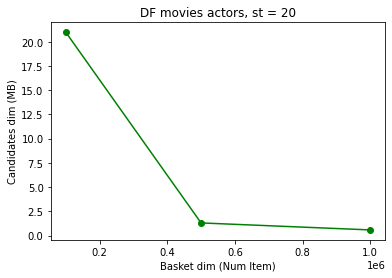

time: 204 ms (started: 2021-06-14 16:06:22 +00:00)


In [ ]:
cand_dim = [20.971624, 1.310824, 0.589936]
basket_dim = [100000, 500000, 1000000]
plt.plot(basket_dim, cand_dim, '-go')
plt.ylabel('Candidates dim (MB)')
plt.xlabel('Basket dim (Num Item)')
plt.title('DF movies actors, st = 20')
plt.show()

### Dataframe movies

In [ ]:
n = len(df_only_films['nconst'].unique())
tot_couples = math.factorial(n) / (math.factorial(2) * math.factorial(n - 2))
print("Number of actors: " + str(n) + " , number of possible couples: " + str(tot_couples))

Number of actors: 1269114 , number of possible couples: 805324537941.0
time: 22.6 s (started: 2021-06-14 16:06:23 +00:00)


In [ ]:
print("A Priori:")
print("Num freq pairs: " + str(len(a_priori(df_only_films, 28))) + " ")

A Priori:
Num Candidates pairs:918450
Dim: 41943152 bytes 
Num freq pairs: 1700 
time: 11.5 s (started: 2021-06-14 16:06:45 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_only_films, 28, my_hash_fun, 217815))) + " ")

PCY:
Num Candidates pairs:918431
Dim: 41943152
Num freq pairs: 1700 
time: 31.2 s (started: 2021-06-14 16:06:57 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_only_films, 28, my_hash_fun, 1089078))) + " ")

PCY:
Num Candidates pairs:344321
Dim: 10485872
Num freq pairs: 1700 
time: 31.1 s (started: 2021-06-14 16:07:28 +00:00)


In [ ]:
print("PCY:")

print("Num freq pairs: " + str(len(PCY(df_only_films, 28, my_hash_fun, 3008156))) + " ")

PCY:
Num Candidates pairs:169288
Dim: 5242984
Num freq pairs: 1700 
time: 30.8 s (started: 2021-06-14 16:07:59 +00:00)


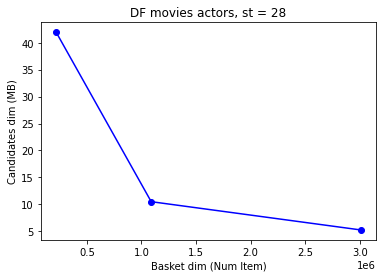

time: 151 ms (started: 2021-06-14 16:08:30 +00:00)


In [ ]:
cand_dim = [41.943152, 10.485872, 5.242984]
basket_dim = [217815, 1089078, 3008156]
plt.plot(basket_dim, cand_dim, '-bo')
plt.ylabel('Candidates dim (MB)')
plt.xlabel('Basket dim (Num Item)')
plt.title('DF movies actors, st = 28')
plt.show()

### Dataframe Full

In [ ]:
n = len(df_visual['nconst'].unique())
tot_couples = math.factorial(n) / (math.factorial(2) * math.factorial(n - 2))
print("Number of actors: " + str(n) + " , number of possible couples: " + str(tot_couples))

Number of actors: 3871313 , number of possible couples: 7493530236328.0
time: 2min 29s (started: 2021-06-14 16:08:30 +00:00)


In [ ]:
print("A Priori:")
print("Num freq pairs: " + str(len(a_priori(df_visual, 290))) + " ")

A Priori:
Num Candidates pairs:784811
Dim: 41943152 bytes 
Num freq pairs: 26693 
time: 1min 39s (started: 2021-06-14 16:11:00 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_visual, 290, my_hash_fun, 664426))) + " ")

PCY:
Num Candidates pairs:174441
Dim: 5242984
Num freq pairs: 26693 
time: 4min 36s (started: 2021-06-14 16:12:39 +00:00)


In [ ]:
print("PCY:")
print("Num freq pairs: " + str(len(PCY(df_visual, 290, my_hash_fun, 3322131))) + " ")

PCY:
Num Candidates pairs:48234
Dim: 2621552
Num freq pairs: 26693 
time: 4min 43s (started: 2021-06-14 16:17:16 +00:00)


In [ ]:
print("PCY:")

print("Num freq pairs: " + str(len(PCY(df_visual, 290, my_hash_fun, 7044262))) + " ")

PCY:
Num Candidates pairs:44893
Dim: 2621552
Num freq pairs: 26693 
time: 4min 44s (started: 2021-06-14 16:21:59 +00:00)


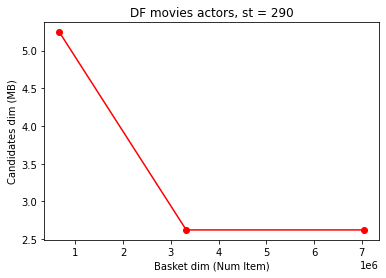

time: 145 ms (started: 2021-06-14 16:26:44 +00:00)


In [ ]:
cand_dim = [5.242984, 2.621552, 2.621552]
basket_dim = [664426, 3322131, 7044262]
plt.plot(basket_dim, cand_dim, '-ro')
plt.ylabel('Candidates dim (MB)')
plt.xlabel('Basket dim (Num Item)')
plt.title('DF movies actors, st = 290')
plt.show()

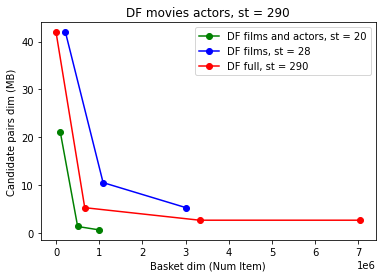

time: 239 ms (started: 2021-06-14 16:26:44 +00:00)


In [ ]:
cand_dim = [20.971624, 1.310824, 0.589936]
basket_dim = [100000, 500000, 1000000]
plt.plot(basket_dim, cand_dim, '-go')
cand_dim = [41.943152, 10.485872, 5.242984]
basket_dim = [217815, 1089078, 3008156]
plt.plot(basket_dim, cand_dim, '-bo')
cand_dim = [41.943152,5.242984, 2.621552, 2.621552]
basket_dim = [0, 664426, 3322131, 7044262]
plt.plot(basket_dim, cand_dim, '-ro')
plt.ylabel('Candidate pairs dim (MB)')
plt.xlabel('Basket dim (Num Item)')
plt.title('DF movies actors, st = 290')
plt.legend(["DF films and actors, st = 20", "DF films, st = 28", "DF full, st = 290"])

plt.savefig('PCY.png')

plt.show()

### Sampled version

In [ ]:
print(len(sampled_PCY('./title.principals.tsv/title.principals.tsv', 290, my_hash_fun, 1000000, 0.8)))

Num Candidates pairs:131003
Dim: 5242984
5990334
26187
time: 7min 30s (started: 2021-06-16 07:39:05 +00:00)


## SON

In [ ]:
import psutil

print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))

Physical cores: 1
Total cores: 2


### DF movies actors

In [ ]:
print(len(SON(df_films_actors, 20, 1)))

1029


In [ ]:
print(len(SON(df_films_actors, 20, 4)))

1029


In [ ]:
print(len(SON(df_films_actors, 20, 6)))

1029


In [ ]:
print(len(SON(df_films_actors, 20, 8)))

1029


In [ ]:
print(len(SON(df_films_actors, 20, 10)))

1029


### DF only movies

In [ ]:
print(len(SON(df_only_films, 28, 1)))

1700


In [ ]:
print(len(SON(df_only_films, 28, 4)))

1700


In [ ]:
print(len(SON(df_only_films, 28, 6)))

1700


In [ ]:
print(len(SON(df_only_films, 28, 8)))

1700


In [ ]:
print(len(SON(df_only_films, 28, 10)))

1700


### DF Full

In [ ]:
print(len(SON(df_visual, 290, 4)))

----------------------------------------ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1212, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving

Exception happened during processing of request from ('127.0.0.1', 44272)
ERROR:root:Exception while sending command.
Tra

Py4JError: ignored

### Plot

In [ ]:
time_df1 = [11.8, 10.2, 12.1, 15.4, 17.6]
time_df2 = [32.8, 25.4, 28.1, 30.6, 45]
# time_df3 = [11.8, 10.2, 12.1, 15.4, 17.6]
num_part = [1, 4, 6, 8, 10]
plt.plot(num_part, time_df1, '-r')
plt.plot(num_part, time_df2, '-g')
plt.plot((4.3),'bo')
plt.plot((10.2),'o')

plt.ylabel('Time (s)')
plt.xlabel('Number of partitions')
plt.legend(["SON movies actors, st = 20","SON movies, st = 28","A Priori movies actors, st = 20", "A Priori movies, st = 28"], bbox_to_anchor=(0.6, 1.165), fancybox=True)
plt.savefig('SON.png')

plt.show()

## Toivonen

### DF films actors

In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_films_actors, 80, 0.6, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result, time: " + str("%.2f" % (time.time() - start)))

Time for sampling: 2.042381525039673
No result, time: 9.89
Time for sampling: 1.801177740097046
No result, time: 9.47
Time for sampling: 1.8162503242492676
No result, time: 9.48
Time for sampling: 1.8224949836730957
No result, time: 9.54
Time for sampling: 1.8161585330963135
25 , time: 9.52
Time for sampling: 1.8175995349884033
No result, time: 9.47
Time for sampling: 1.8134305477142334
No result, time: 9.42
Time for sampling: 1.7538049221038818
25 , time: 9.47
Time for sampling: 1.7623693943023682
No result, time: 9.38
Time for sampling: 1.798091173171997
25 , time: 9.49
time: 1min 35s (started: 2021-06-14 19:02:57 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_films_actors, 100, 0.5, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str(time.time() - start))
  else:
    print("No result" + str(time.time() - start))

Time for sampling: 1.998781681060791
No result9.073845863342285
Time for sampling: 1.9606869220733643
No result9.195152759552002
Time for sampling: 1.9293546676635742
No result9.060336828231812
Time for sampling: 1.9631717205047607
No result9.18625545501709
Time for sampling: 1.9441840648651123
No result9.046992063522339
Time for sampling: 1.959244966506958
No result9.042151689529419
Time for sampling: 1.923858404159546
No result9.127630472183228
Time for sampling: 1.922555685043335
No result9.173765420913696
Time for sampling: 1.960766077041626
No result9.236297369003296
Time for sampling: 1.9475376605987549
No result9.136834859848022
time: 1min 31s (started: 2021-06-14 19:04:32 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_films_actors, 120, 0.4, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str(time.time() - start))
  else:
    print("No result" + str(time.time() - start))

Time for sampling: 1.875411033630371
No result8.581810474395752
Time for sampling: 1.855759859085083
No result8.635251998901367
Time for sampling: 1.8300533294677734
No result8.57957124710083
Time for sampling: 1.8350393772125244
6 , time: 8.6875479221344
Time for sampling: 1.8558220863342285
No result8.58965802192688
Time for sampling: 1.8336234092712402
No result8.614153385162354
Time for sampling: 1.8678631782531738
No result8.565728425979614
Time for sampling: 1.854503870010376
No result8.632659196853638
Time for sampling: 1.865107774734497
No result8.61565375328064
Time for sampling: 1.8497562408447266
No result8.589053869247437
time: 1min 26s (started: 2021-06-14 19:06:03 +00:00)


### DF only films 

In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_only_films, 100, 0.6, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result" + str("%.2f" % (time.time() - start)))

Time for sampling: 2.5143351554870605
No result24.02
Time for sampling: 2.479419231414795
42 , time: 23.77
Time for sampling: 2.459909439086914
42 , time: 23.45
Time for sampling: 2.4836955070495605
42 , time: 23.60
Time for sampling: 2.4299867153167725
42 , time: 23.43
Time for sampling: 2.5347208976745605
No result23.61
Time for sampling: 2.460509777069092
No result23.55
Time for sampling: 2.4658825397491455
42 , time: 23.75
Time for sampling: 2.4967002868652344
42 , time: 23.69
Time for sampling: 2.472914934158325
42 , time: 23.58
time: 3min 56s (started: 2021-06-14 19:07:29 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_only_films, 130, 0.5, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result, time: " + str("%.2f" % (time.time() - start)))

Time for sampling: 2.567094326019287
17 , time: 22.45
Time for sampling: 2.567736864089966
17 , time: 22.37
Time for sampling: 2.5039801597595215
No result, time: 22.24
Time for sampling: 2.545482873916626
17 , time: 22.37
Time for sampling: 2.521592378616333
No result, time: 22.16
Time for sampling: 2.517610549926758
17 , time: 22.31
Time for sampling: 2.5375516414642334
No result, time: 22.19
Time for sampling: 2.565732955932617
17 , time: 22.46
Time for sampling: 2.55399751663208
17 , time: 22.54
Time for sampling: 2.5213775634765625
No result, time: 22.07
time: 3min 43s (started: 2021-06-14 19:11:26 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_only_films, 160, 0.4, 0.8)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result, time: " + str("%.2f" % (time.time() - start)))

Time for sampling: 2.592860221862793
No result, time: 21.29
Time for sampling: 2.5417728424072266
No result, time: 21.17
Time for sampling: 2.53969144821167
No result, time: 21.10
Time for sampling: 2.559075117111206
No result, time: 21.40
Time for sampling: 2.551494836807251
7 , time: 21.41
Time for sampling: 2.5382907390594482
No result, time: 21.20
Time for sampling: 2.5668413639068604
No result, time: 21.10
Time for sampling: 2.56337308883667
7 , time: 21.19
Time for sampling: 2.5435791015625
No result, time: 21.28
Time for sampling: 2.567152976989746
No result, time: 21.26
time: 3min 32s (started: 2021-06-14 19:15:09 +00:00)


### DF full

In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_visual, 900, 0.4, 0.9)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result" + str("%.2f" % (time.time() - start)))

Time for sampling: 28.930926084518433
No result211.83
Time for sampling: 28.2190101146698
3488 , time: 210.74
Time for sampling: 27.96038293838501
3488 , time: 211.60
Time for sampling: 28.137105703353882
3488 , time: 212.50
Time for sampling: 28.084845542907715
No result210.08
Time for sampling: 27.603060722351074
No result208.20
Time for sampling: 28.77798295021057
3488 , time: 208.50
Time for sampling: 28.00181484222412
3488 , time: 208.34
Time for sampling: 27.970293283462524
No result205.98
Time for sampling: 27.72694969177246
No result204.64
time: 34min 52s (started: 2021-06-14 19:18:41 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_visual, 1200, 0.3, 0.9)  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result" + str("%.2f" % (time.time() - start)))

Time for sampling: 27.872518062591553
No result191.51
Time for sampling: 27.80534601211548
No result188.93
Time for sampling: 27.642632722854614
1817 , time: 189.36
Time for sampling: 27.496355533599854
No result191.06
Time for sampling: 28.270933866500854
No result188.32
Time for sampling: 28.214771270751953
No result188.58
Time for sampling: 28.319875717163086
1817 , time: 192.25
Time for sampling: 30.506987810134888
1817 , time: 192.68
Time for sampling: 29.2321994304657
1817 , time: 196.24
Time for sampling: 29.4410343170166
No result194.16
time: 31min 53s (started: 2021-06-14 20:26:51 +00:00)


In [ ]:
for i in range(10):
  start = time.time()
  res = toivonen(df_visual, 1400, 0.3, 0.9 )  
  if res:
    print(str(len(res)) + " , time: " + str("%.2f" % (time.time() - start)))
  else:
    print("No result" + str("%.2f" % (time.time() - start)))

Time for sampling: 28.973427057266235
No result192.01
Time for sampling: 29.152103424072266
1206 , time: 187.62
Time for sampling: 28.82076907157898
1206 , time: 191.61
Time for sampling: 28.775410413742065
1206 , time: 191.35
Time for sampling: 29.389435529708862
1206 , time: 191.75
Time for sampling: 29.006077527999878
1206 , time: 192.28
Time for sampling: 29.275707006454468
1206 , time: 192.61
Time for sampling: 29.344544649124146
1206 , time: 192.77
Time for sampling: 29.218058109283447
1206 , time: 189.04
Time for sampling: 29.112985134124756
No result187.35
time: 31min 48s (started: 2021-06-14 20:58:44 +00:00)


## Plot

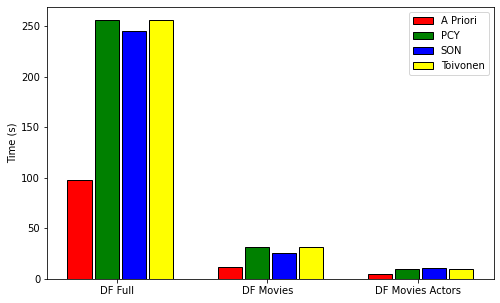

time: 222 ms (started: 2021-06-14 12:45:34 +00:00)


In [ ]:
plt.figure(figsize=[8, 5])
a_pr = [98, 11.5, 4.81]
pcy = [256, 31.2, 10]
son = [245,25.4,10.2]
toiv = [210, 24, 9.3]

X = np.arange(len(a_pr))
plt.bar(X, a_pr, color = 'r', edgecolor = 'black', width = 0.16)
plt.bar(X + 0.18, pcy, color = 'g', edgecolor = 'black', width = 0.16)
plt.bar(X + 2 * 0.180, son, color = 'b', edgecolor = 'black', width = 0.16)
plt.bar(X + 3 * 0.18, pcy, color = 'yellow', edgecolor = 'black', width = 0.16)
plt.xticks([i + 0.25 for i in range(3)], ['DF Full', 'DF Movies', 'DF Movies Actors'])

plt.legend(['A Priori', 'PCY','SON', 'Toivonen'])
plt.ylabel('Time (s)')
# Displaying the bar plot
plt.savefig('time_res.png')
plt.show()

# *DEBUG* 

In this cells there is the code in order to see different informations about the most frequent pairs

In [ ]:
names = pd.read_csv('./name.basics.tsv/name.basics.tsv',
                    sep='\t')
films = pd.read_csv('./title.basics.tsv/title.basics.tsv',   
                        usecols= ['tconst','titleType', 'primaryTitle',  'startYear'], 
                        sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 44.3 s (started: 2021-06-16 08:17:00 +00:00)


In [ ]:
def get_information(res):
  max = (0,0)
  for i in res:
    if i[1] > max[1]:
      max = i
  person = max[0][0]
  print("Actor names:")
  for i in max[0]:
    display(names.loc[names['nconst'] == i])
  print("\n Number of times they appear together: " + str(max[1]))
  title = df_visual.loc[df_visual['nconst'] == person].values[0][0]
  print("\n One film he worked on:")
  display(films.loc[films['tconst'] == title])
  return

time: 8.23 ms (started: 2021-06-16 08:17:44 +00:00)


In [ ]:
get_information(a_priori(df_films_actors, 20))

Num Candidates pairs:382224
Dim: 20971624 bytes 
Actor names:


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
589876,nm0623427,Prem Nazir,1926,1989,actor,"tt0279309,tt0318122,tt0257461,tt0334137"


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
6957,nm0006982,Adoor Bhasi,1929,1990,"actor,director,music_department","tt0155472,tt0156920,tt0268954,tt0282889"



 Number of times they appear together: 237

 One film he worked on:


,tconst,titleType,primaryTitle,startYear
58977,tt0060105,movie,Anarkali,1966


time: 10.7 s (started: 2021-06-16 08:17:44 +00:00)
